In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
#setting dataset path
data_dir= Path(r"E:\PDF\Drittes Semester\ANN2\project\daily+and+sports+activities\data")
print(data_dir.exists())

True


In [3]:
#I picked one example file for inspecting
activity= "a06"
person="p4"
file="s42.txt"
file_path= data_dir/activity/ person/ file
print(file_path)
print(file_path.exists())

E:\PDF\Drittes Semester\ANN2\project\daily+and+sports+activities\data\a06\p4\s42.txt
True


In [4]:
#loading that one file
df=pd.read_csv(file_path, header= None,sep= ",") 
print(df.shape)
df.head

(125, 45)


<bound method NDFrame.head of           0       1       2         3         4         5        6        7   \
0    10.9870 -3.0218  3.2745  0.256080 -0.157260  0.103140 -0.73630 -0.41494   
1    11.1260 -3.6450  3.2342  0.045666  0.155530  0.127030 -0.73985 -0.41030   
2     8.3520 -4.1704  3.0979  0.166890  0.095584  0.118950 -0.74367 -0.40431   
3    13.4420 -4.8557  4.9524  0.361930 -0.609570  0.184840 -0.74392 -0.39764   
4    11.9550 -4.9413  3.4111  0.316770  0.242290  0.386990 -0.75135 -0.38710   
..       ...     ...     ...       ...       ...       ...      ...      ...   
120   7.8557 -3.2439  3.9557  0.127230 -0.149480 -0.098604 -0.77551 -0.32624   
121   7.8635 -3.4854  4.3727  0.075554 -0.160780 -0.054799 -0.78239 -0.31080   
122   8.7662 -3.1431  4.7899 -0.014580 -0.117180 -0.119970 -0.79433 -0.31685   
123   8.8144 -2.7305  4.1293 -0.102810 -0.093974 -0.152030 -0.76390 -0.32121   
124   8.2145 -2.6341  4.4876 -0.207740  0.030008 -0.157990 -0.77608 -0.32192   

         

In [5]:
#checking the timesteps vs features
print("Rows = (time steps):", df.shape[0])
print("Columns = (features):", df.shape[1])

Rows = (time steps): 125
Columns = (features): 45


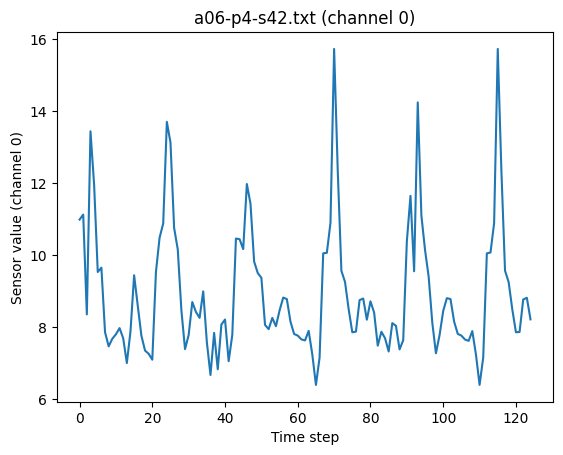

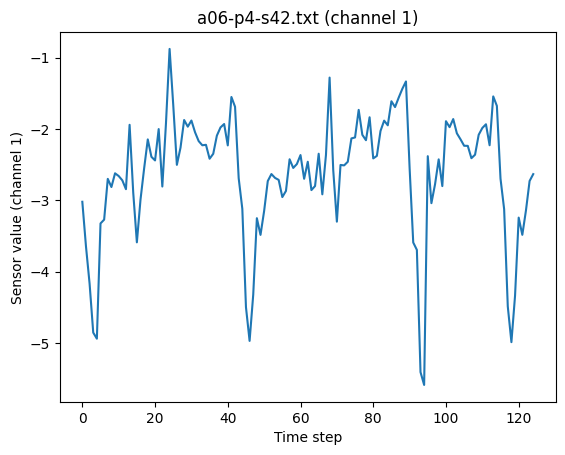

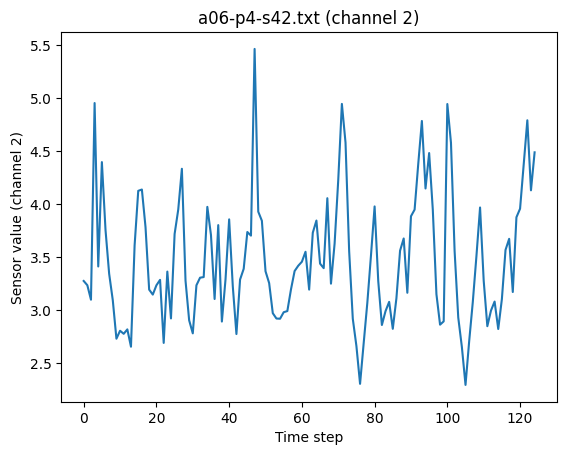

In [6]:
# then i plotted a few channels of that example
for col in range(min(3, df.shape[1])):  #first up to 3 channels
    plt.figure()
    plt.plot(df.iloc[:, col])
    plt.xlabel("Time step")
    plt.ylabel(f"Sensor value (channel {col})")
    plt.title(f"{activity}-{person}-{file} (channel {col})")
    plt.show()

In [7]:
#defining a helper that loads one txt file as a (time_steps × 45) NumPy array.
def load_single_sequence(file_path: Path) ->np.ndarray:
    
    df= pd.read_csv(file_path, header=None, sep=",")
    return df.to_numpy()
    
#then i need to walk through all folders then collect sequences and labels
def load_all_sequences(data_dir: Path):
    X_list= []    #X_list: list of numpy arrays (one for each sequence)
    y=[]         #y:numpy array of activity labels(1–19)
    subjects=[]  #subjects: NumPy array of subject ids(1–8)

    #sorting for reproducibility
    for a_folder in sorted(data_dir.glob("a*")):
        activity_label=int(a_folder.name[1:])   #'a06' will be 6

        for p_folder in sorted(a_folder.glob("p*")):
            subject_id=int(p_folder.name[1:])   #'p4' will be  4

            for file_path in sorted(p_folder.glob("s*.txt")):
                seq =load_single_sequence(file_path)
                X_list.append(seq)
                y.append(activity_label)
                subjects.append(subject_id)

    y=np.array(y, dtype=np.int64)
    subjects=np.array(subjects,dtype=np.int64)
    return X_list, y,subjects

#now lets loading the whole dataset and cheking the shape and length
X_list,y, subjects= load_all_sequences(data_dir)

print("Number of sequences:", len(X_list))
print("Labels shape:", y.shape)
print("Subjects shape:", subjects.shape)
print("First sequence shape:", X_list[0].shape)

# now i want to now if all sequences have same length?
lengths= [seq.shape[0] for seq in X_list]
print("Min length:", min(lengths), "Max length:", max(lengths))


Number of sequences: 9120
Labels shape: (9120,)
Subjects shape: (9120,)
First sequence shape: (125, 45)
Min length: 125 Max length: 125


In [8]:
#so all lengths are equal so  stack into one big tensor N×T×45
T= X_list[0].shape[0]
X= np.stack(X_list)   # our shape: (N= number of sequence, T= time step per sequence, 45= number of features)
print("Final X shape:", X.shape)

Final X shape: (9120, 125, 45)


In [9]:
np.isnan(X).any()

False

In [10]:
# The 19 activities are: 
activity_names = ["sitting (A0)", "standing (A1)", 
"lying on back side(A2)","lying on right side (A3)", 
"ascending stairs(A4)","descending stairs (A5)",
"standing in an elevator still (A6)","moving around in an elevator (A7)", 
"walking in a parking lot (A8)", 
"walking on a flat treadmill with a speed of 4 km/h(A9)","walking with slop on a treadmill with a speed of 4 km/h(A10)",
"running on a treadmill with a speed of 8 km/h (A11)", 
"exercising on a stepper (A12)", "exercising on a cross trainer (A13)", 
"cycling on an exercise bike in horizontal (A14)","cycling on an exercise bike in vertical positions (A15)",
"rowing (A16)","jumping (A17)","playing basketball (A18)"]

print(activity_names)

['sitting (A0)', 'standing (A1)', 'lying on back side(A2)', 'lying on right side (A3)', 'ascending stairs(A4)', 'descending stairs (A5)', 'standing in an elevator still (A6)', 'moving around in an elevator (A7)', 'walking in a parking lot (A8)', 'walking on a flat treadmill with a speed of 4 km/h(A9)', 'walking with slop on a treadmill with a speed of 4 km/h(A10)', 'running on a treadmill with a speed of 8 km/h (A11)', 'exercising on a stepper (A12)', 'exercising on a cross trainer (A13)', 'cycling on an exercise bike in horizontal (A14)', 'cycling on an exercise bike in vertical positions (A15)', 'rowing (A16)', 'jumping (A17)', 'playing basketball (A18)']


In [11]:
# I want to display a single instance with the activity label and subject id.
idx=9000   
sample=X[idx]          
label= y[idx]           
subject_id= subjects[idx]  
print("Index:", idx)
print("Subject ID:", subject_id)
print("Activity label:", label)
print("Sample shape:", sample.shape)

df_sample = pd.DataFrame(sample)
df_sample.head()

Index: 9000
Subject ID: 7
Activity label: 19
Sample shape: (125, 45)


,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,7.0604,-3.7725,3.14780,0.14058,-0.25395,-0.32800,-0.97516,-0.16461,0.11052,8.6657,...,-0.25819,-6.9392,4.86330,0.16024,3.2263,0.090530,-0.13635,0.86731,-0.084173,0.35605
1,5.2135,-3.3099,0.45134,0.41624,-1.26820,0.22636,-0.96871,-0.16401,0.14380,7.0065,...,-0.29058,-6.9805,5.27040,3.42460,4.9074,0.237050,0.59950,0.86655,-0.039335,0.36964
2,6.4009,-3.5948,-1.10060,-0.78697,-1.13350,0.57711,-0.96483,-0.15462,0.16079,4.4110,...,-0.32820,-7.5268,-9.05340,5.68470,4.3531,-0.017927,1.72790,0.86634,-0.009969,0.37014
3,7.9894,-2.1963,-2.07150,-1.09250,-0.53587,0.51956,-0.95892,-0.14062,0.18413,3.6776,...,-0.36318,-6.3123,-15.46300,2.32690,5.8073,0.232750,0.57698,0.86482,0.018167,0.37924
4,8.3774,-2.3382,-2.56190,-0.59647,0.62599,0.45871,-0.95654,-0.12115,0.19772,5.3341,...,-0.38970,-6.8809,0.24382,-9.61330,2.3963,0.978820,-0.57607,0.85828,0.084722,0.38466


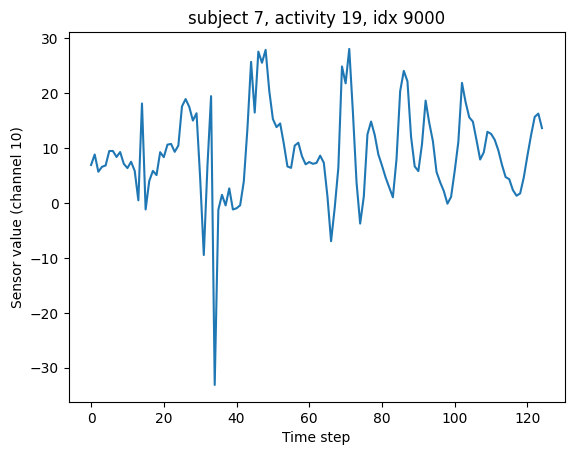

In [12]:
#and then i want to visualize one channel of it
plt.plot(sample[:, 10])   #channel 10 for example
plt.xlabel("Time step")
plt.ylabel("Sensor value (channel 10)")
plt.title(f"subject {subject_id}, activity {label}, idx {idx}")
plt.show()


In [13]:
# spliting the datasets by subject
#now i want to  have the people from 1 to 6 in train and validation set.
#persons 7 and 8 be in test set and check to dont have leackage.

print("unique subjects:", np.unique(subjects))
train_subjects= [1,2,3,4,5,6]
test_subjects= [7,8]

train_mask= np.isin(subjects, train_subjects)
test_mask= np.isin(subjects, test_subjects)

X_train_full= X[train_mask]
y_train_full= y[train_mask]

X_test=X[test_mask]
y_test=y[test_mask]

print("Train_full shape:", X_train_full.shape, "y:", y_train_full.shape)
print("Test shape:", X_test.shape, "y:", y_test.shape)

# now i need a validation set.
X_train,X_val, y_train, y_val= train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

print("Final train shape:", X_train.shape, "y:", y_train.shape)
print("Val shape:", X_val.shape, "y:", y_val.shape)
print("Test shape:", X_test.shape, "y:", y_test.shape)

unique subjects: [1 2 3 4 5 6 7 8]
Train_full shape: (6840, 125, 45) y: (6840,)
Test shape: (2280, 125, 45) y: (2280,)
Final train shape: (5472, 125, 45) y: (5472,)
Val shape: (1368, 125, 45) y: (1368,)
Test shape: (2280, 125, 45) y: (2280,)


In [14]:
# check for subject leakage
subj_train_full= set(subjects[train_mask])
subj_test=set(subjects[test_mask])

print("Train_full subjects:", subj_train_full)
print("Test subjects:", subj_test)
print("Overlap (should be empty):", subj_train_full & subj_test)


Train_full subjects: {1, 2, 3, 4, 5, 6}
Test subjects: {8, 7}
Overlap (should be empty): set()


In [15]:
#normalizing all the 45 features just from the taining set(to provide information leakage)
#StandardScalar expets data shaped like (n-samples and n-features). 
#so temporarily I reshape it to 2d , scale it and then reshaped it back. 

N_train, T, F= X_train.shape
N_val= X_val.shape[0]
N_test= X_test.shape[0]

scaler= StandardScaler()

#reshaping to 2D: (N*T, F) so scaler sees all time steps as samples
X_train_2d= X_train.reshape(-1, F)
X_val_2d= X_val.reshape(-1, F)
X_test_2d= X_test.reshape(-1, F)

#fiting on training data only
scaler.fit(X_train_2d)

# then transforming on all splits and reshape them into again 3d
X_train_scaled= scaler.transform(X_train_2d).reshape(N_train, T, F)
X_val_scaled = scaler.transform(X_val_2d).reshape(N_val, T, F)
X_test_scaled= scaler.transform(X_test_2d).reshape(N_test, T, F)

print("Scaled train shape:", X_train_scaled.shape)
print("Scaled val shape:",   X_val_scaled.shape)
print("Scaled test shape:",  X_test_scaled.shape)


Scaled train shape: (5472, 125, 45)
Scaled val shape: (1368, 125, 45)
Scaled test shape: (2280, 125, 45)


In [16]:
#i map labels from 1-19 to 0-18
T= X_train_scaled.shape[1]
F= X_train_scaled.shape[2]
num_classes= len(np.unique(y_train))
print("input shape:", (T , F))
print("number of classes:", num_classes)

#so we should shifting labels
y_train_c= y_train - 1
y_val_c= y_val - 1
y_test_c= y_test -1
print("Label range after shift: train min =", y_train_c.min(), "max =", y_train_c.max())

input shape: (125, 45)
number of classes: 19
Label range after shift: train min = 0 max = 18


# 1) 1D-CNN Model (Baseline Model)

In [17]:
#I build a structure as fallows:
#conv1D -> batchnorm -> maxpool
#conv1D -> batchnorm -> globalaveragepooling
# dense -> dropout -> output

model= keras.Sequential()
model.add(keras.layers.Input(shape = (T,F)))
model.add(keras.layers.Conv1D(filters=64, kernel_size=5,activation="relu", padding= "same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(filters=128, kernel_size=5, activation="relu", padding= "same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.GlobalAveragePooling1D())

model.add(keras.layers.Dense(64, activation= "relu"))
model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(num_classes, activation= "softmax"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 125, 64)             │          14,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 125, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 62, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 62, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 62, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 19)                  │           1,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,811 (257.07 KB)

 Trainable params: 65,427 (255.57 KB)

 Non-trainable params: 384 (1.50 KB)

In [18]:
#compile and train he model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history= model.fit(X_train_scaled, y_train_c,validation_data=(X_val_scaled, y_val_c), batch_size=64,epochs=100, verbose=1)


Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4002 - loss: 1.9961 - val_accuracy: 0.8121 - val_loss: 1.2754
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8315 - loss: 0.6985 - val_accuracy: 0.9569 - val_loss: 0.3624
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9004 - loss: 0.4201 - val_accuracy: 0.9861 - val_loss: 0.1072
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9273 - loss: 0.2891 - val_accuracy: 0.9920 - val_loss: 0.0464
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9440 - loss: 0.2269 - val_accuracy: 0.9942 - val_loss: 0.0257
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9643 - loss: 0.1600 - val_accuracy: 0.9890 - val_loss: 0.0250
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9702 - loss: 0.1330 - val_accuracy: 0.9971 - val_loss: 0.0157
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9722 - loss: 0.1141 - val_accuracy: 0.

In [19]:
#evaluating on testset
test_loss, test_acc= model.evaluate(X_test_scaled, y_test_c, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test loss: 2.1978
Test accuracy: 0.8399


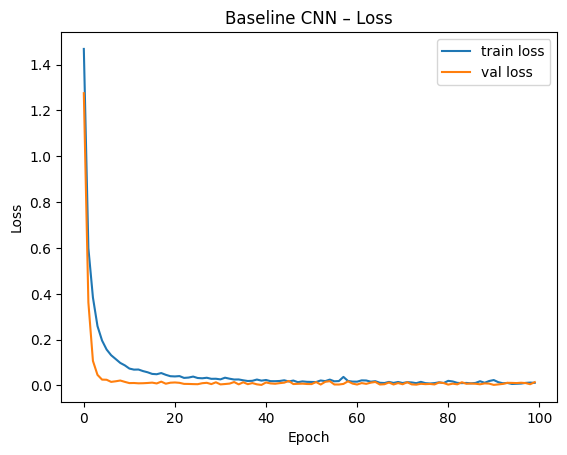

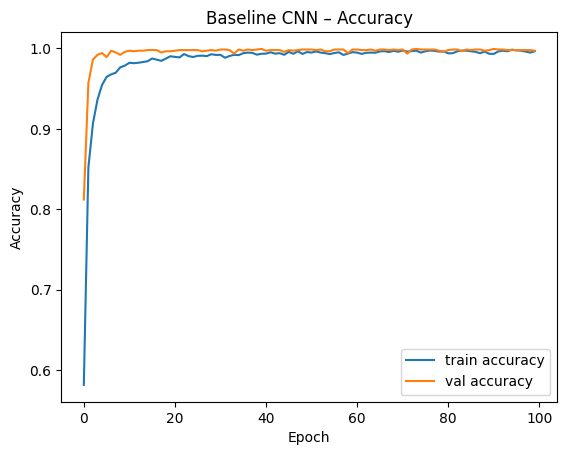

In [20]:
# loss
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Baseline CNN – Loss")
plt.savefig("Baseline_Loss.png", dpi=300, bbox_inches="tight")
plt.show()

# accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Baseline CNN – Accuracy")
plt.savefig("Baseline_Accuracy.png", dpi=300, bbox_inches="tight")
plt.show()


as i tried some tiny changes in learning rate and dropout, but they did not jump test accuracy, i think the generalization issue is more about the architecture than tiny hyperparameters.

In [21]:

#1)predicting class probabilities for test set
y_test_proba_baseline= model.predict(X_test_scaled)

#2) convert probabilities to predicted class indices (0..18)
y_test_pred_baseline= np.argmax(y_test_proba_baseline, axis=1)

#3)confusion matrix
cm_baseline=confusion_matrix(y_test_c, y_test_pred_baseline)
print("Confusion matrix shape:", cm_baseline.shape)
print(cm_baseline)

#4)detailed metrics per class
print("\nClassification report (per class):")
print(classification_report(y_test_c, y_test_pred_baseline))


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion matrix shape: (19, 19)
[[120   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0  60   0   0   0   0   0  60   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0 120   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0 120   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0 120   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0  44   0  60  16   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0  62  58   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   1   0   0   0   0  18  86   5   0   0   0   0   5   0   0   0   0
    5]
 [  0   0   0   0   0   0   0  30  60   0   0   0   0   0   0   0   0   0
   30]
 [  0   0   0   0   0   0   0   0   0 120   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0  60  60   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0

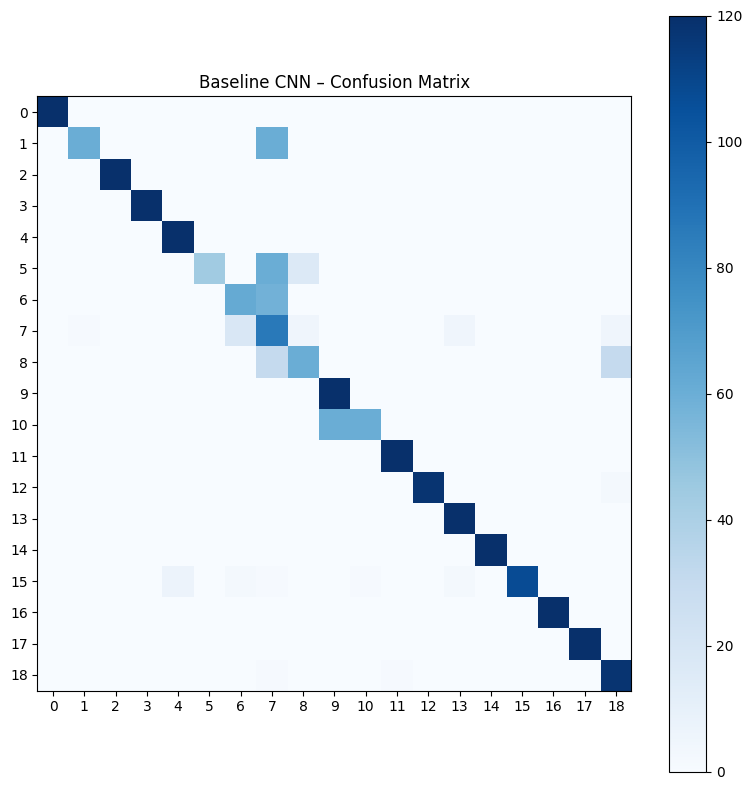

In [22]:
#plotting the confusion matrix as a heatmap.
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(cm_baseline, interpolation="nearest", cmap="Blues")
plt.title("Baseline CNN – Confusion Matrix")
plt.colorbar()
plt.xticks(range(num_classes))
plt.yticks(range(num_classes))
plt.tight_layout()
plt.savefig("confusion_matrix_Baseline.png", dpi=300, bbox_inches="tight")
plt.show()



In [23]:

model_name= "Baseline CNN "  
cm= confusion_matrix(y_test_c, y_test_pred_baseline)
cm_off= cm.copy()
np.fill_diagonal(cm_off, 0)
k= 6  
flat_idx= np.argsort(cm_off.ravel())[::-1]  
rows= []
for idx in flat_idx:
    i, j= np.unravel_index(idx, cm_off.shape)
    count= int(cm_off[i, j])
    if count== 0:
        break
    rows.append({
        "True label": i,
        "Pred label": j,
        "True activity": activity_names[i],
        "Pred activity": activity_names[j],
        "Count (samples)": count})
    if len(rows)== k:
        break

top_conf_df= pd.DataFrame(rows)
display(top_conf_df)

top_conf_df.to_csv(f"{model_name}_top_confusions.csv", index=False)
print(f"Saved: {model_name}_top_confusions.csv")


,True label,Pred label,True activity,Pred activity,Count (samples)
0,10,9,walking with slop on a treadmill with a speed ...,walking on a flat treadmill with a speed of 4 ...,60
1,5,7,descending stairs (A5),moving around in an elevator (A7),60
2,1,7,standing (A1),moving around in an elevator (A7),60
3,6,7,standing in an elevator still (A6),moving around in an elevator (A7),58
4,8,18,walking in a parking lot (A8),playing basketball (A18),30
5,8,7,walking in a parking lot (A8),moving around in an elevator (A7),30


Saved: Baseline CNN _top_confusions.csv


The largest confusions are:

True class 10 → predicted class 9 (60/120 samples = 50%)

True class 1 → predicted class 7 (60/120 ≈ 50%)

True class 8 → predicted class 18 (58/120 ≈ 48%)

True class 5 → predicted class 7 (42/120 = 43%)

True class 6 → predicted class 7 (48/120 ≈ 40%)

This indicates that some activities produce very similar sensor patterns, so the model tends to “collapse” them into a few classes. In particular, class 7 is predicted very often when the model is uncertain, because multiple other classes (1, 5, and 6) are frequently misclassified as 7.  These observations motivate the next step of the project: multi-sensor fusion, where signals from different body locations are processed separately and then fused, with the goal of reducing these confusions by using more location-specific information.


# 2) Multi-Sensor Fusion Model

## What “multi-sensor fusion” means in this dataset

we have 5 sensor units on the body:

- Torso (T)

- Right Arm (RA)

- Left Arm (LA)

- Right Leg (RL)

- Left Leg (LL)

Each unit has 9 channels (3 accel + 3 gyro + 3 magnet).
So total features: 5 × 9 = 45.

### The fusion idea:
Instead of feeding all 45 channels into one CNN, we create 5 parallel branches:
each branch processes its own 9 channels
then we concatenate their learned features
then a final classifier predicts the activity.


In this dataset, the 45 features are typically ordered by unit blocks (9+9+9+9+9).
So we know (from dataset description):
- T: 0–8
- RA: 9–17
- LA: 18–26
- RL: 27–35
- LL: 36–44

In [24]:
#Defining feature groups (9 channels per body location)
groups= {"T":  (0, 9), "RA": (9, 18),"LA": (18, 27),"RL": (27, 36),"LL": (36, 45)}

for name, (a,b) in groups.items():
    print(name, "channels:", a, "to", b-1, "count:", b-a)

T channels: 0 to 8 count: 9
RA channels: 9 to 17 count: 9
LA channels: 18 to 26 count: 9
RL channels: 27 to 35 count: 9
LL channels: 36 to 44 count: 9


In [25]:
#Building the multi branch fusion model

def build_fusion_cnn(T, F, num_classes, groups):
    inp= keras.Input(shape=(T, F), name="all_sensors")
    branch_outputs=[]

    for name,(a, b) in groups.items():
        x= layers.Lambda(lambda z, a=a, b=b: z[:, :, a:b], name=f"slice_{name}")(inp)

        x=layers.Conv1D(64, kernel_size=5,padding="same",activation="relu",name=f"conv1_{name}")(x)
        x= layers.BatchNormalization(name=f"bn1_{name}")(x)
        x=layers.MaxPooling1D(pool_size=2,name=f"pool1_{name}")(x)

        x=layers.Conv1D(128,kernel_size=5,padding="same", activation="relu", name=f"conv2_{name}")(x)
        x =layers.BatchNormalization(name=f"bn2_{name}")(x)

        x =layers.GlobalAveragePooling1D(name=f"gap_{name}")(x)
        branch_outputs.append(x)

    #now fusing features from all body locations
    x= layers.Concatenate(name="fusion_concat")(branch_outputs)

    #classifier
    x =layers.Dense(128, activation="relu",name="dense1")(x)
    x =layers.Dropout(0.5, name="dropout1")(x)
    out=layers.Dense(num_classes,activation="softmax", name="output")(x)

    model= keras.Model(inputs=inp, outputs=out, name="Fusion_CNN")
    return model
fusion_model =build_fusion_cnn(T,F,num_classes, groups)
fusion_model.summary()


Model: "Fusion_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ all_sensors (InputLayer)      │ (None, 125, 45)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ slice_T (Lambda)              │ (None, 125, 9)            │               0 │ all_sensors[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ slice_RA (Lambda)             │ (None, 125, 9)            │               0 │ all_sensors[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ slice_LA (Lambda)             │ (None, 125, 9)            │               0 │ all_sensors[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ slice_RL (Lambda)             │ (None, 125, 9)            │               0 │ all_sensors[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ slice_LL (Lambda)             │ (None, 125, 9)            │               0 │ all_sensors[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_T (Conv1D)              │ (None, 125, 64)           │           2,944 │ slice_T[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_RA (Conv1D)             │ (None, 125, 64)           │           2,944 │ slice_RA[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_LA (Conv1D)             │ (None, 125, 64)           │           2,944 │ slice_LA[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_RL (Conv1D)             │ (None, 125, 64)           │           2,944 │ slice_RL[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_LL (Conv1D)             │ (None, 125, 64)           │           2,944 │ slice_LL[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn1_T (BatchNormalization)    │ (None, 125, 64)           │             256 │ conv1_T[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn1_RA (BatchNormalization)   │ (None, 125, 64)           │             256 │ conv1_RA[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn1_LA (BatchNormalization)   │ (None, 125, 64)           │             256 │ conv1_LA[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn1_RL (BatchNormalization)   │ (None, 125, 64)           │             256 │ conv1_RL[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn1_LL (BatchNormalization)   │ (None, 125, 64)           │             256 │ conv1_LL[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_T (MaxPooling1D)        │ (None, 62, 64)            │               0 │ bn1_T[0][0]                │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 308,499 (1.18 MB)

 Trainable params: 306,579 (1.17 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [26]:
#Training it exactly like the baseline model(same split and same scaling)
fusion_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

fusion_history=fusion_model.fit(
    X_train_scaled, y_train_c,
    validation_data=(X_val_scaled, y_val_c),
    epochs=100,
    batch_size=64,
    verbose=1)


Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.6735 - loss: 1.2076 - val_accuracy: 0.9554 - val_loss: 0.9953
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9688 - loss: 0.1320 - val_accuracy: 0.9927 - val_loss: 0.1970
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9806 - loss: 0.0756 - val_accuracy: 0.9934 - val_loss: 0.0449
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9886 - loss: 0.0474 - val_accuracy: 0.9905 - val_loss: 0.0303
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9876 - loss: 0.0404 - val_accuracy: 0.9963 - val_loss: 0.0151
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9936 - loss: 0.0286 - val_accuracy: 0.9868 - val_loss: 0.0390
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9911 - loss: 0.0274 - val_accuracy: 0.9978 - val_loss: 0.0087
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9955 - loss: 0.0201 - val_accuracy: 0.

In [27]:
# evaluating
fusion_test_loss, fusion_test_acc = fusion_model.evaluate(X_test_scaled, y_test_c, verbose=0)
print("Fusion Test loss:", fusion_test_loss)
print("Fusion Test accuracy:", fusion_test_acc)


Fusion Test loss: 1.9289060831069946
Fusion Test accuracy: 0.8714912533760071


In [28]:
model_to_eval=fusion_model   

y_prob_fusion= model_to_eval.predict(X_test_scaled, verbose=0)
y_pred_fusion= np.argmax(y_prob_fusion, axis=1)
print("Classification report (per class):")
print(classification_report(y_test_c, y_pred_fusion, digits=2))

Classification report (per class):
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       120
           1       1.00      0.50      0.67       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       0.94      1.00      0.97       120
           5       0.99      0.92      0.95       120
           6       0.67      0.52      0.58       120
           7       0.42      0.71      0.53       120
           8       0.98      0.50      0.66       120
           9       0.67      1.00      0.81       120
          10       0.98      0.52      0.68       120
          11       1.00      1.00      1.00       120
          12       1.00      1.00      1.00       120
          13       0.98      0.99      0.99       120
          14       1.00      1.00      1.00       120
          15       1.00      0.92      0.96       120
          16       1.00      1.00      1.00   

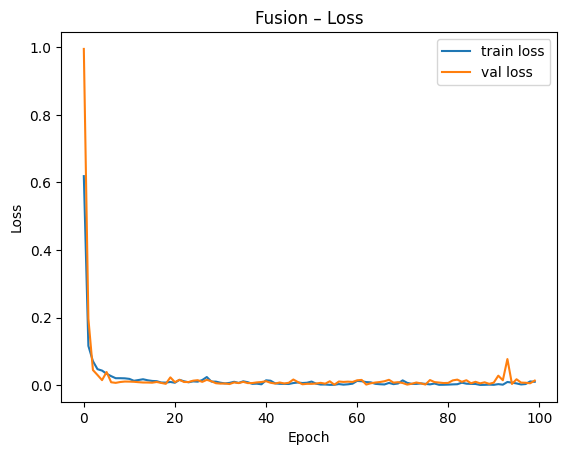

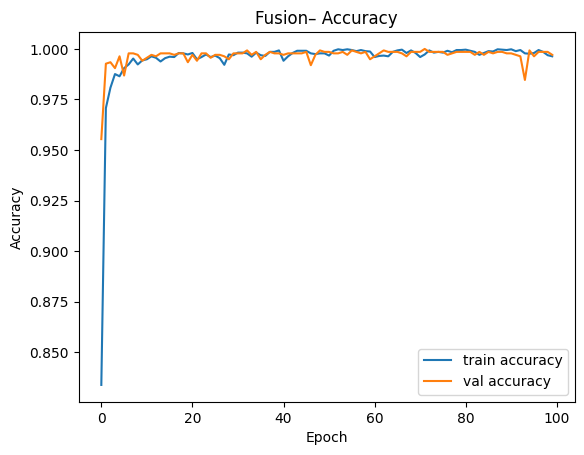

In [29]:
# loss
plt.figure()
plt.plot(fusion_history.history["loss"], label="train loss")
plt.plot(fusion_history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Fusion – Loss")
plt.savefig("Fusion_Loss.png", dpi=300, bbox_inches="tight")
plt.show()

# accuracy
plt.figure()
plt.plot(fusion_history.history["accuracy"], label="train accuracy")
plt.plot(fusion_history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Fusion– Accuracy")
plt.savefig("Fusion_Accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

Confusion matrix shape: (19, 19)


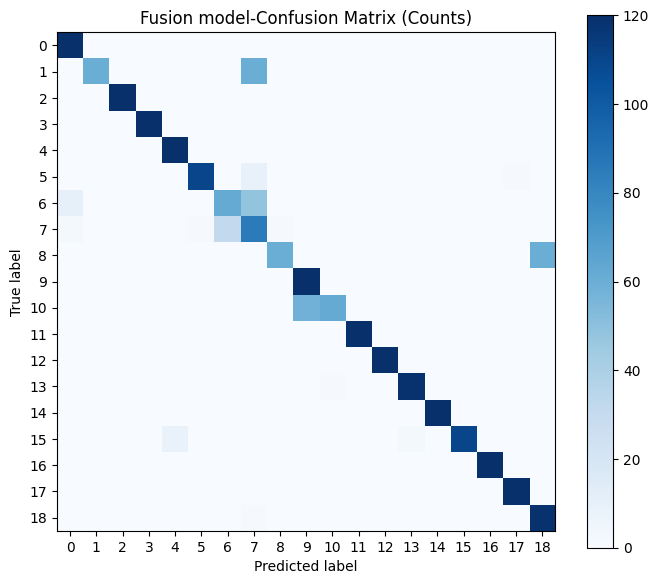

In [30]:
# confusion matrix
cm_fusion=confusion_matrix(y_test_c, y_pred_fusion)
print("Confusion matrix shape:", cm_fusion.shape)

plt.figure(figsize=(7,6))
plt.imshow(cm_fusion, interpolation="nearest", cmap="Blues")
plt.title("Fusion model-Confusion Matrix (Counts)")
plt.colorbar()

num_classes=cm_fusion.shape[0]
plt.xticks(range(num_classes))
plt.yticks(range(num_classes))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("confusion_matrix_Fusion.png", dpi=300, bbox_inches="tight")
plt.show()


In [31]:
model_name= "Fusion "  
cm=confusion_matrix(y_test_c, y_pred_fusion)
cm_off= cm.copy()
np.fill_diagonal(cm_off, 0)
k= 6
flat_idx= np.argsort(cm_off.ravel())[::-1]  
rows=[]
for idx in flat_idx:
    i, j= np.unravel_index(idx, cm_off.shape)
    count= int(cm_off[i, j])
    if count== 0:
        break
    rows.append({
        "True label": i,
        "Pred label": j,
        "True activity": activity_names[i],
        "Pred activity": activity_names[j],
        "Count (samples)": count})
    if len(rows)== k:
        break

top_conf_df= pd.DataFrame(rows)
display(top_conf_df)

top_conf_df.to_csv(f"{model_name}_top_confusions.csv", index=False)
print(f"Saved: {model_name}_top_confusions.csv")


,True label,Pred label,True activity,Pred activity,Count (samples)
0,8,18,walking in a parking lot (A8),playing basketball (A18),60
1,1,7,standing (A1),moving around in an elevator (A7),60
2,10,9,walking with slop on a treadmill with a speed ...,walking on a flat treadmill with a speed of 4 ...,58
3,6,7,standing in an elevator still (A6),moving around in an elevator (A7),48
4,7,6,moving around in an elevator (A7),standing in an elevator still (A6),31
5,6,0,standing in an elevator still (A6),sitting (A0),10


Saved: Fusion _top_confusions.csv


# 3) TCN Model

In [32]:
# the structure is as follows;
# One TCN residual block:
# Conv1D (dilated) -> Batch Normalization -> ReLU -> Dropout -> 
# Conv1D (dilated) -> Batch Normalization -> ReLU -> Dropout + residual/skip connection

def tcn_block(x, filters, kernel_size, dilation_rate, dropout_rate=0.2, name_prefix="tcn"):
   
    shortcut= x

    x=layers.Conv1D(filters, kernel_size, padding="same",
                      dilation_rate=dilation_rate, name=f"{name_prefix}_conv1_d{dilation_rate}")(x)
    x=layers.BatchNormalization(name=f"{name_prefix}_bn1_d{dilation_rate}")(x)
    x=layers.Activation("relu", name=f"{name_prefix}_relu1_d{dilation_rate}")(x)
    x=layers.Dropout(dropout_rate, name=f"{name_prefix}_drop1_d{dilation_rate}")(x)

    x=layers.Conv1D(filters, kernel_size, padding="same",
                      dilation_rate=dilation_rate, name=f"{name_prefix}_conv2_d{dilation_rate}")(x)
    x=layers.BatchNormalization(name=f"{name_prefix}_bn2_d{dilation_rate}")(x)
    x= layers.Activation("relu", name=f"{name_prefix}_relu2_d{dilation_rate}")(x)
    x=layers.Dropout(dropout_rate, name=f"{name_prefix}_drop2_d{dilation_rate}")(x)

    ##matching channels for residual
    if shortcut.shape[-1] != filters:
        shortcut= layers.Conv1D(filters, 1, padding="same", name=f"{name_prefix}_resmatch_d{dilation_rate}")(shortcut)

    x=layers.Add(name=f"{name_prefix}_add_d{dilation_rate}")([shortcut, x])
    x= layers.Activation("relu", name=f"{name_prefix}_outrelu_d{dilation_rate}")(x)
    return x


def build_tcn_model(input_shape, num_classes,
                    filters=64, kernel_size=5, dilations=(1, 2, 4, 8, 16),
                    dropout_rate=0.2):
    inp= keras.Input(shape=input_shape, name="input_ts")
    x= inp

    for d in dilations:
        x= tcn_block(x, filters=filters, kernel_size=kernel_size,
                      dilation_rate=d, dropout_rate=dropout_rate,
                      name_prefix="tcn")

    x= layers.GlobalAveragePooling1D(name="gap")(x)
    x= layers.Dense(128, activation="relu", name="dense1")(x)
    x= layers.Dropout(0.5, name="dropout_head")(x)
    out=layers.Dense(num_classes, activation="softmax", name="output")(x)

    model=keras.Model(inp, out, name="TCN_Model")
    return model


input_shape= (T, F)
tcn_model= build_tcn_model(input_shape, num_classes,filters=64, kernel_size=5, dilations=(1,2,4,8,16),dropout_rate=0.2)
tcn_model.summary()


Model: "TCN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ts (InputLayer)         │ (None, 125, 45)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_conv1_d1 (Conv1D)         │ (None, 125, 64)           │          14,464 │ input_ts[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_bn1_d1                    │ (None, 125, 64)           │             256 │ tcn_conv1_d1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_relu1_d1 (Activation)     │ (None, 125, 64)           │               0 │ tcn_bn1_d1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_drop1_d1 (Dropout)        │ (None, 125, 64)           │               0 │ tcn_relu1_d1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_conv2_d1 (Conv1D)         │ (None, 125, 64)           │          20,544 │ tcn_drop1_d1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_bn2_d1                    │ (None, 125, 64)           │             256 │ tcn_conv2_d1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_relu2_d1 (Activation)     │ (None, 125, 64)           │               0 │ tcn_bn2_d1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_resmatch_d1 (Conv1D)      │ (None, 125, 64)           │           2,944 │ input_ts[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_drop2_d1 (Dropout)        │ (None, 125, 64)           │               0 │ tcn_relu2_d1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_add_d1 (Add)              │ (None, 125, 64)           │               0 │ tcn_resmatch_d1[0][0],     │
│                               │                           │                 │ tcn_drop2_d1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_outrelu_d1 (Activation)   │ (None, 125, 64)           │               0 │ tcn_add_d1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_conv1_d2 (Conv1D)         │ (None, 125, 64)           │          20,544 │ tcn_outrelu_d1[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_bn1_d2                    │ (None, 125, 64)           │             256 │ tcn_conv1_d2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_relu1_d2 (Activation)     │ (None, 125, 64)           │               0 │ tcn_bn1_d2[0][0]           │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 215,635 (842.32 KB)

 Trainable params: 214,355 (837.32 KB)

 Non-trainable params: 1,280 (5.00 KB)

In [33]:
# compiling and training
tcn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

tcn_history= tcn_model.fit(X_train_scaled, y_train_c,validation_data=(X_val_scaled, y_val_c),
    epochs=100,batch_size=64,verbose=1)


Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.3486 - loss: 2.5603 - val_accuracy: 0.7844 - val_loss: 0.7529
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.8983 - loss: 0.3907 - val_accuracy: 0.9861 - val_loss: 0.0730
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9603 - loss: 0.1555 - val_accuracy: 0.9898 - val_loss: 0.0361
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9818 - loss: 0.0804 - val_accuracy: 0.9898 - val_loss: 0.0392
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9819 - loss: 0.0767 - val_accuracy: 0.9942 - val_loss: 0.0240
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9897 - loss: 0.0432 - val_accuracy: 0.9825 - val_loss: 0.0524
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.9869 - loss: 0.0644 - val_accuracy: 0.9934 - val_loss: 0.0213
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9876 - loss: 0.0470 - val_accuracy: 0

In [34]:
tcn_test_loss, tcn_test_acc= tcn_model.evaluate(X_test_scaled, y_test_c, verbose=0)
print("TCN Test loss:", tcn_test_loss)
print("TCN Test accuracy:", tcn_test_acc)

TCN Test loss: 1.812231183052063
TCN Test accuracy: 0.8311403393745422


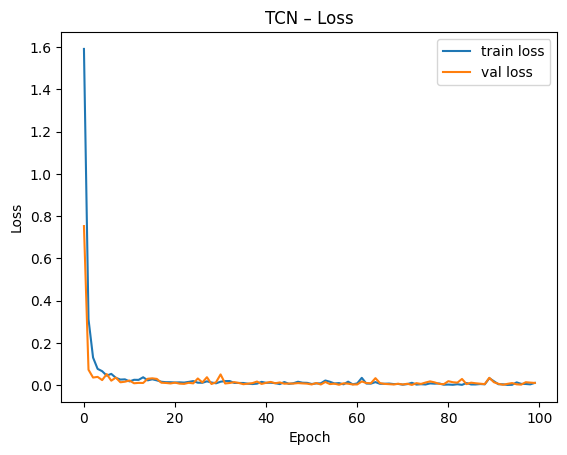

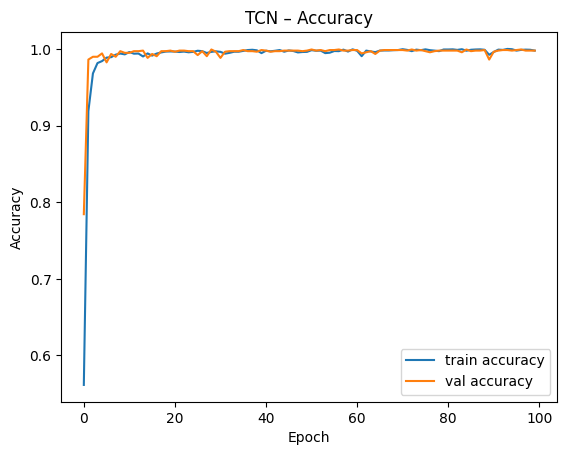

In [35]:
plt.figure()
plt.plot(tcn_history.history["loss"], label="train loss")
plt.plot(tcn_history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("TCN – Loss")
plt.savefig("TCN_Loss.png", dpi=300, bbox_inches="tight")
plt.show()


plt.figure()
plt.plot(tcn_history.history["accuracy"], label="train accuracy")
plt.plot(tcn_history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("TCN – Accuracy")
plt.savefig("TCN_Accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

Classification report (per class):
              precision    recall  f1-score   support

           0       1.00      0.50      0.67       120
           1       0.92      0.50      0.65       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       0.94      1.00      0.97       120
           5       0.99      0.67      0.80       120
           6       0.70      0.52      0.60       120
           7       0.33      0.74      0.46       120
           8       0.59      0.50      0.54       120
           9       0.98      0.99      0.98       120
          10       1.00      0.51      0.67       120
          11       1.00      1.00      1.00       120
          12       0.79      0.98      0.88       120
          13       0.98      0.99      0.98       120
          14       0.67      1.00      0.80       120
          15       1.00      0.90      0.95       120
          16       1.00      1.00      1.00   

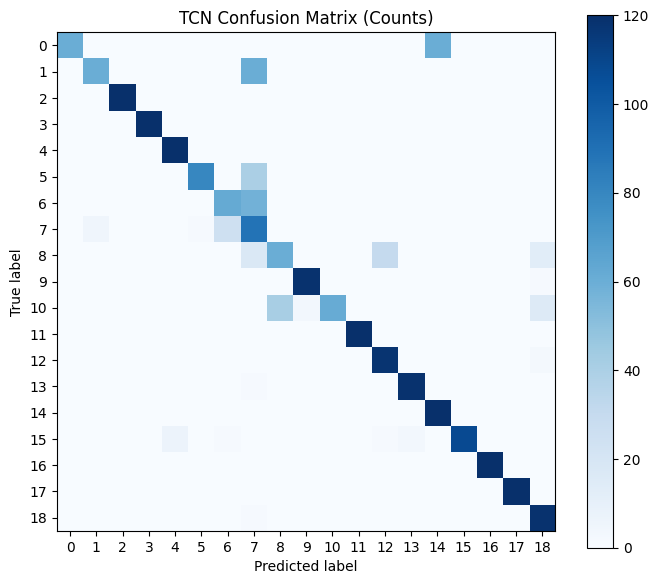

In [36]:
model_to_eval=tcn_model    

y_prob_tcn= model_to_eval.predict(X_test_scaled, verbose=0)
y_pred_tcn= np.argmax(y_prob_tcn, axis=1)
print("Classification report (per class):")
print(classification_report(y_test_c, y_pred_tcn, digits=2))

cm_tcn= confusion_matrix(y_test_c, y_pred_tcn)
print("Confusion matrix shape:", cm_tcn.shape)


plt.figure(figsize=(7,6))
plt.imshow(cm_tcn, interpolation="nearest", cmap="Blues")
plt.title("TCN Confusion Matrix (Counts)")
plt.colorbar()

num_classes=cm_tcn.shape[0]
plt.xticks(range(num_classes))
plt.yticks(range(num_classes))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("TCN confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


In [37]:
model_name= "TCN "  
cm= confusion_matrix(y_test_c, y_pred_tcn)
cm_off= cm.copy()
np.fill_diagonal(cm_off, 0)
k= 6  
flat_idx= np.argsort(cm_off.ravel())[::-1]  
rows=[]
for idx in flat_idx:
    i, j=np.unravel_index(idx, cm_off.shape)
    count=int(cm_off[i,j])
    if count==0:
        break
    rows.append({
        "True label": i,
        "Pred label": j,
        "True activity":activity_names[i],
        "Pred activity":activity_names[j],
        "Count (samples)": count })
    if len(rows)== k:
        break

top_conf_df=pd.DataFrame(rows)
display(top_conf_df)

top_conf_df.to_csv(f"{model_name}_top_confusions.csv", index=False)
print(f"Saved: {model_name}_top_confusions.csv")


,True label,Pred label,True activity,Pred activity,Count (samples)
0,0,14,sitting (A0),cycling on an exercise bike in horizontal (A14),60
1,1,7,standing (A1),moving around in an elevator (A7),60
2,6,7,standing in an elevator still (A6),moving around in an elevator (A7),58
3,10,8,walking with slop on a treadmill with a speed ...,walking in a parking lot (A8),41
4,5,7,descending stairs (A5),moving around in an elevator (A7),40
5,8,12,walking in a parking lot (A8),exercising on a stepper (A12),30


Saved: TCN _top_confusions.csv


### **TCN tuned v1**

In [38]:
tcn_model_v1= build_tcn_model(input_shape=(T, F), num_classes=num_classes,
    filters=128,kernel_size=5,dilations=(1, 2, 4, 8, 16),dropout_rate=0.1)

tcn_model_v1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])

callbacks= [EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)]

tcnv1_history= tcn_model_v1.fit(X_train_scaled, y_train_c,validation_data=(X_val_scaled, y_val_c),
    epochs=200,  batch_size=64,callbacks=callbacks, verbose=1)

v1_loss, v1_acc= tcn_model_v1.evaluate(X_test_scaled, y_test_c, verbose=0)

print("Tuned TCN v1 Test loss:", v1_loss)
print("Tuned TCN v1 Test accuracy:", v1_acc)


Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 249ms/step - accuracy: 0.4409 - loss: 2.4114 - val_accuracy: 0.9335 - val_loss: 0.4552 - learning_rate: 3.0000e-04
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 0.9427 - loss: 0.2072 - val_accuracy: 0.9883 - val_loss: 0.0542 - learning_rate: 3.0000e-04
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - accuracy: 0.9756 - loss: 0.0930 - val_accuracy: 0.9861 - val_loss: 0.0496 - learning_rate: 3.0000e-04
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.9860 - loss: 0.0585 - val_accuracy: 0.9883 - val_loss: 0.0369 - learning_rate: 3.0000e-04
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - accuracy: 0.9894 - loss: 0.0402 - val_accuracy: 0.9920 - val_loss: 0.0241 - learning_rate: 3.0000e-04
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.9871 - loss: 0.0611 - val_accuracy: 0.9963 - val_loss: 0.0143 - learning_rate: 3.0000e-04
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 359ms/ste

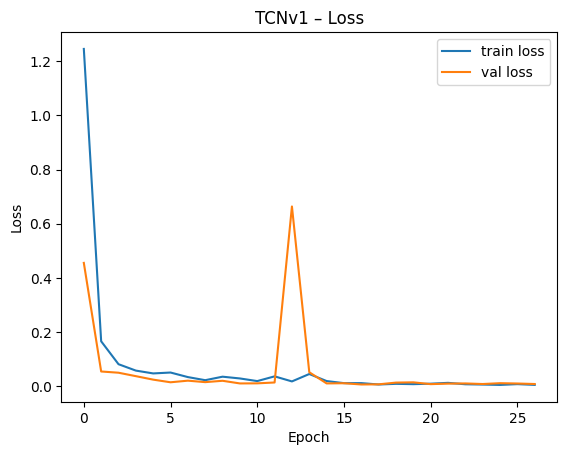

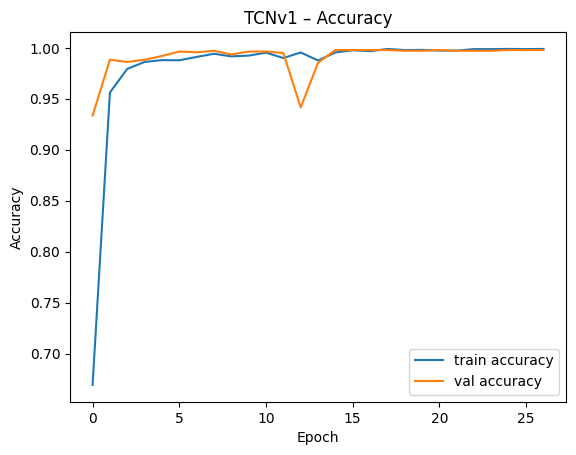

In [39]:
# loss
plt.figure()
plt.plot(tcnv1_history.history["loss"], label="train loss")
plt.plot(tcnv1_history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("TCNv1 – Loss")
plt.savefig("TCNv1_Loss.png", dpi=300, bbox_inches="tight")
plt.show()

# accuracy
plt.figure()
plt.plot(tcnv1_history.history["accuracy"], label="train accuracy")
plt.plot(tcnv1_history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("TCNv1 – Accuracy")
plt.savefig("TCNv1_Accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

Classification report (per class):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       0.94      0.50      0.65       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       0.98      1.00      0.99       120
           5       1.00      0.50      0.67       120
           6       0.71      0.52      0.60       120
           7       0.34      0.76      0.47       120
           8       0.97      0.50      0.66       120
           9       0.67      0.98      0.79       120
          10       0.82      0.50      0.62       120
          11       0.94      1.00      0.97       120
          12       0.89      1.00      0.94       120
          13       0.97      0.93      0.95       120
          14       1.00      1.00      1.00       120
          15       1.00      0.89      0.94       120
          16       1.00      1.00      1.00   

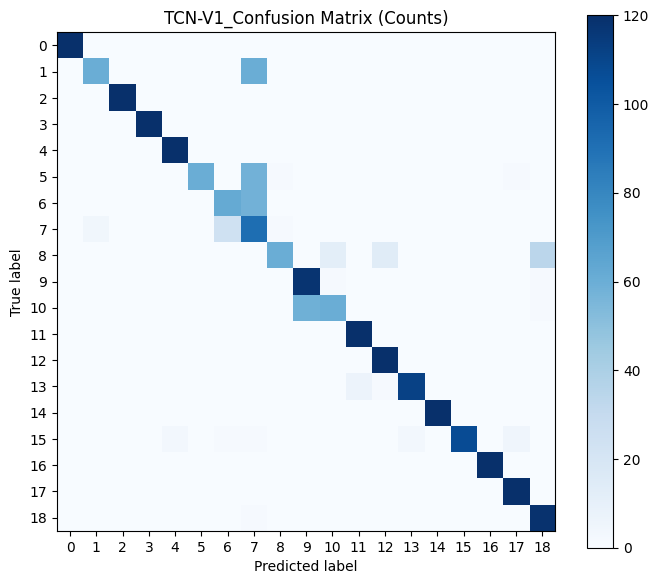

In [40]:
model_to_eval= tcn_model_v1    # TCN v1

y_prob_tcnv1= model_to_eval.predict(X_test_scaled, verbose=0)
y_pred_tcnv1= np.argmax(y_prob_tcnv1, axis=1)
print("Classification report (per class):")
print(classification_report(y_test_c, y_pred_tcnv1, digits=2))

cm_tcnv1= confusion_matrix(y_test_c, y_pred_tcnv1)
print("Confusion matrix shape:", cm_tcnv1.shape)


plt.figure(figsize=(7,6))
plt.imshow(cm_tcnv1, interpolation="nearest", cmap="Blues")
plt.title("TCN-V1_Confusion Matrix (Counts)")
plt.colorbar()

num_classes= cm.shape[0]
plt.xticks(range(num_classes))
plt.yticks(range(num_classes))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("TCN-V1_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


In [41]:
model_name= "TCN_v1 "  
cm= confusion_matrix(y_test_c, y_pred_tcnv1)
cm_off= cm.copy()
np.fill_diagonal(cm_off, 0)
k= 6  
flat_idx= np.argsort(cm_off.ravel())[::-1]  
rows=[]
for idx in flat_idx:
    i, j= np.unravel_index(idx, cm_off.shape)
    count= int(cm_off[i, j])
    if count== 0:
        break
    rows.append({
        "True label": i,
        "Pred label": j,
        "True activity": activity_names[i],
        "Pred activity": activity_names[j],
        "Count (samples)": count})
    if len(rows)== k:
        break

top_conf_df= pd.DataFrame(rows)
display(top_conf_df)

top_conf_df.to_csv(f"{model_name}_top_confusions.csv", index=False)
print(f"Saved: {model_name}_top_confusions.csv")


,True label,Pred label,True activity,Pred activity,Count (samples)
0,1,7,standing (A1),moving around in an elevator (A7),60
1,10,9,walking with slop on a treadmill with a speed ...,walking on a flat treadmill with a speed of 4 ...,59
2,5,7,descending stairs (A5),moving around in an elevator (A7),58
3,6,7,standing in an elevator still (A6),moving around in an elevator (A7),58
4,8,18,walking in a parking lot (A8),playing basketball (A18),34
5,7,6,moving around in an elevator (A7),standing in an elevator still (A6),24


Saved: TCN_v1 _top_confusions.csv


### **TCN tuned v2**

In [42]:
tcn_model_v2= build_tcn_model(input_shape=(T, F),num_classes=num_classes,
    filters=128,kernel_size=3, dilations=(1, 2, 4, 8, 16, 32), dropout_rate=0.1)

tcn_model_v2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])

tcnv2_history= tcn_model_v2.fit(
    X_train_scaled, y_train_c,validation_data=(X_val_scaled, y_val_c),
    epochs=200, batch_size=64,callbacks=callbacks,verbose=1)

v2_loss, v2_acc= tcn_model_v2.evaluate(X_test_scaled, y_test_c, verbose=0)

print("Tuned TCN v2 Test loss:", v2_loss)
print("Tuned TCN v2 Test accuracy:", v2_acc)


Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 53s 465ms/step - accuracy: 0.3498 - loss: 3.1888 - val_accuracy: 0.8823 - val_loss: 0.6187 - learning_rate: 3.0000e-04
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 444ms/step - accuracy: 0.8986 - loss: 0.3691 - val_accuracy: 0.9788 - val_loss: 0.1012 - learning_rate: 3.0000e-04
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 37s 434ms/step - accuracy: 0.9675 - loss: 0.1356 - val_accuracy: 0.9890 - val_loss: 0.0359 - learning_rate: 3.0000e-04
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 437ms/step - accuracy: 0.9794 - loss: 0.0867 - val_accuracy: 0.9949 - val_loss: 0.0201 - learning_rate: 3.0000e-04
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - accuracy: 0.9868 - loss: 0.0557 - val_accuracy: 0.9949 - val_loss: 0.0209 - learning_rate: 3.0000e-04
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.9874 - loss: 0.0446 - val_accuracy: 0.9949 - val_loss: 0.0197 - learning_rate: 3.0000e-04
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/ste

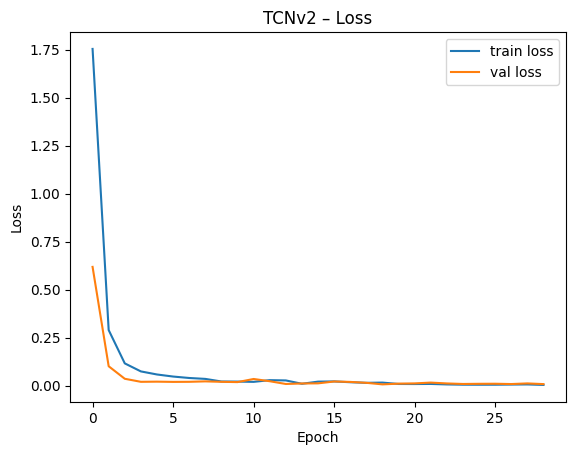

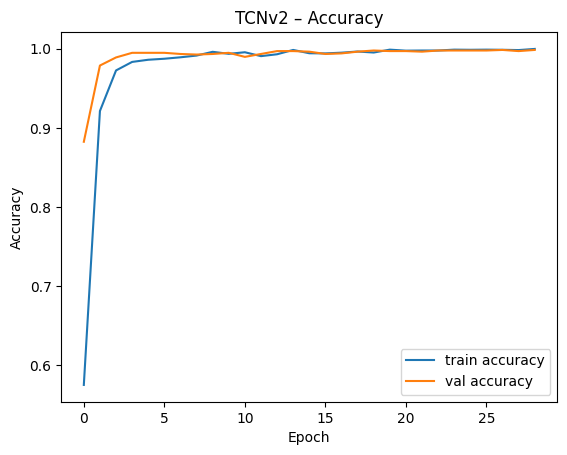

In [43]:
#loss
plt.figure()
plt.plot(tcnv2_history.history["loss"], label="train loss")
plt.plot(tcnv2_history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("TCNv2 – Loss")
plt.savefig("TCNv2_Loss.png", dpi=300, bbox_inches="tight")
plt.show()

# accuracy
plt.figure()
plt.plot(tcnv2_history.history["accuracy"], label="train accuracy")
plt.plot(tcnv2_history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("TCNv2 – Accuracy")
plt.savefig("TCNv2_Accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

Classification report (per class):
              precision    recall  f1-score   support

           0       1.00      0.50      0.67       120
           1       0.94      0.50      0.65       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       0.92      1.00      0.96       120
           5       0.98      0.49      0.66       120
           6       0.75      0.52      0.61       120
           7       0.31      0.78      0.44       120
           8       0.44      0.50      0.47       120
           9       0.86      0.78      0.82       120
          10       1.00      0.49      0.66       120
          11       0.95      1.00      0.98       120
          12       0.71      1.00      0.83       120
          13       1.00      0.94      0.97       120
          14       0.92      1.00      0.96       120
          15       1.00      0.92      0.96       120
          16       1.00      1.00      1.00   

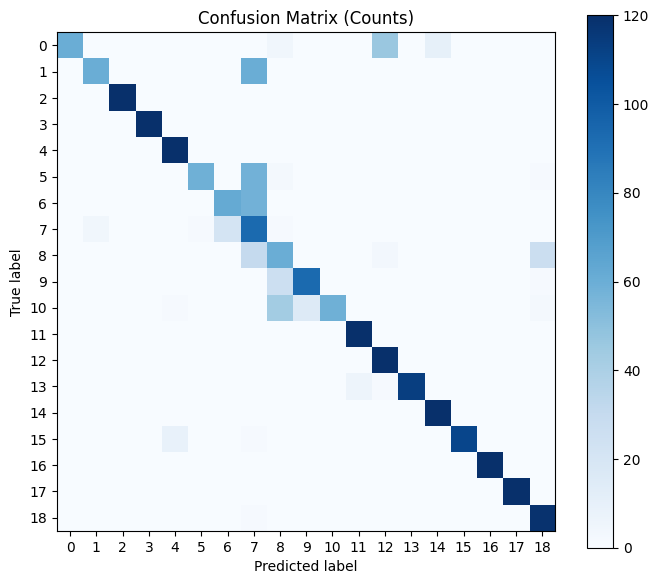

In [44]:
model_to_eval= tcn_model_v2    

y_prob_tcnv2= model_to_eval.predict(X_test_scaled, verbose=0)
y_pred_tcnv2= np.argmax(y_prob_tcnv2, axis=1)
print("Classification report (per class):")
print(classification_report(y_test_c, y_pred_tcnv2, digits=2))

cm_tcnv2= confusion_matrix(y_test_c, y_pred_tcnv2)
print("Confusion matrix shape:", cm_tcnv2.shape)


plt.figure(figsize=(7,6))
plt.imshow(cm_tcnv2, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix (Counts)")
plt.colorbar()

num_classes= cm_tcnv2.shape[0]
plt.xticks(range(num_classes))
plt.yticks(range(num_classes))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("TCN-V2_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()
    

In [45]:
model_name= "TCN-v2 "  
cm= confusion_matrix(y_test_c, y_pred_tcnv2)
cm_off= cm.copy()
np.fill_diagonal(cm_off, 0)
k =6  
flat_idx= np.argsort(cm_off.ravel())[::-1]  
rows=[]
for idx in flat_idx:
    i, j= np.unravel_index(idx, cm_off.shape)
    count= int(cm_off[i, j])
    if count== 0:
        break
    rows.append({
        "True label": i,
        "Pred label": j,
        "True activity": activity_names[i],
        "Pred activity": activity_names[j],
        "Count (samples)": count})
    if len(rows)== k:
        break

top_conf_df= pd.DataFrame(rows)
display(top_conf_df)

top_conf_df.to_csv(f"{model_name}_top_confusions.csv", index=False)
print(f"Saved: {model_name}_top_confusions.csv")



,True label,Pred label,True activity,Pred activity,Count (samples)
0,1,7,standing (A1),moving around in an elevator (A7),60
1,6,7,standing in an elevator still (A6),moving around in an elevator (A7),58
2,5,7,descending stairs (A5),moving around in an elevator (A7),58
3,0,12,sitting (A0),exercising on a stepper (A12),46
4,10,8,walking with slop on a treadmill with a speed ...,walking in a parking lot (A8),43
5,8,7,walking in a parking lot (A8),moving around in an elevator (A7),30


Saved: TCN-v2 _top_confusions.csv


Changing kernel size and dilation depth did not improve performance. The main misclassification pairs remained stable, indicating that simple TCN hyperparameter tuning is insufficient for resolving the hardest class overlaps in this dataset.

**Results:**
- Baseline CNN achieved ~0.86.

- TCN v1 with EarlyStopping and LR scheduling achieved 0.85 (competitive).

- TCN v2 (kernel=3, larger dilation) dropped to 0.82, and major confusions persisted.

Therefore, I proceed with a hybrid temporal model (CNN+BiLSTM) to better separate confusing activity pairs.

# 4) CNN + BiLSTM Model

In [46]:
# Architecture:
# Conv1D blocks: detect short motion patterns
# BiLSTM: learn how those patterns evolve across time
# Dense softmax: 19-class classification

cnn_bilstm=keras.Sequential()

#input
cnn_bilstm.add(keras.layers.Input(shape=(T, F)))

#CNN feature extractor (local temporal patterns)
cnn_bilstm.add(keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu"))
cnn_bilstm.add(keras.layers.BatchNormalization())
cnn_bilstm.add(keras.layers.MaxPooling1D(pool_size=2))

cnn_bilstm.add(keras.layers.Conv1D(128, kernel_size=5, padding="same", activation="relu"))
cnn_bilstm.add(keras.layers.BatchNormalization())
cnn_bilstm.add(keras.layers.MaxPooling1D(pool_size=2))

#BiLSTM (sequence modeling)
cnn_bilstm.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False)))

#classifier head
cnn_bilstm.add(keras.layers.Dense(64, activation="relu"))
cnn_bilstm.add(keras.layers.Dropout(0.5))
cnn_bilstm.add(keras.layers.Dense(num_classes, activation="softmax"))

cnn_bilstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

cnn_bilstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 125, 64)             │          14,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 125, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 62, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 62, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 62, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 31, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 19)                  │           1,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,627 (643.07 KB)

 Trainable params: 164,243 (641.57 KB)

 Non-trainable params: 384 (1.50 KB)

In [47]:
classes= np.unique(y_train_c)
weights= compute_class_weight(class_weight="balanced",classes=classes, y=y_train_c)
class_weight= dict(zip(classes, weights))
print(class_weight)

cnn_bilstm_history=cnn_bilstm.fit(
    X_train_scaled,y_train_c,
    validation_data=(X_val_scaled, y_val_c),
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1)

loss_cb, acc_cb= cnn_bilstm.evaluate(X_test_scaled, y_test_c, verbose=0)
print("CNN+BiLSTM Test loss:", loss_cb)
print("CNN+BiLSTM Test accuracy:", acc_cb)


{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0}
Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.3343 - loss: 2.4023 - val_accuracy: 0.7727 - val_loss: 1.5101 - learning_rate: 3.0000e-04
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8202 - loss: 0.9246 - val_accuracy: 0.9686 - val_loss: 0.3832 - learning_rate: 3.0000e-04
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9204 - loss: 0.4068 - val_accuracy: 0.9846 - val_loss: 0.1107 - learning_rate: 3.0000e-04
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9667 - loss: 0.2127 - val_accuracy: 0.9912 - val_loss: 0.0472 - learning_rate: 3.0000e-04
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9675 - loss: 0.1642 - val_accuracy: 0.9949 - val_loss: 0.0325 - learning_rate: 3.0000e-04
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - acc

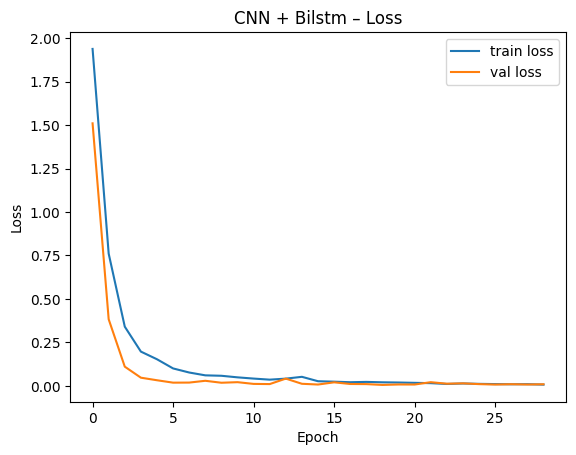

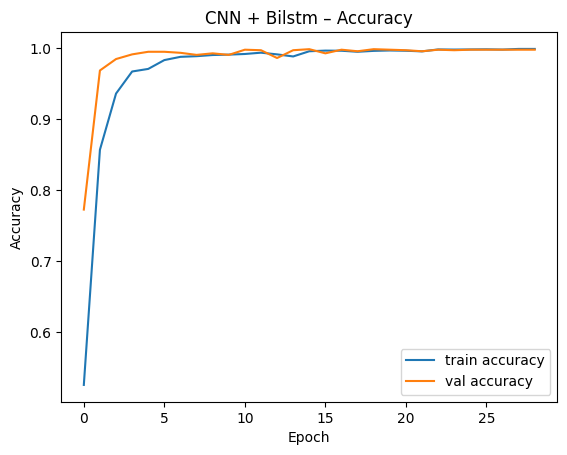

In [48]:
#loss
plt.figure()
plt.plot(cnn_bilstm_history.history["loss"], label="train loss")
plt.plot(cnn_bilstm_history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("CNN + Bilstm – Loss")
plt.savefig("CNN + Bilstm_Loss.png", dpi=300, bbox_inches="tight")
plt.show()

# accuracy
plt.figure()
plt.plot(cnn_bilstm_history.history["accuracy"], label="train accuracy")
plt.plot(cnn_bilstm_history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN + Bilstm – Accuracy")
plt.savefig("CNN + Bilstm_Accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

Classification report (per class):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       120
           1       0.89      0.39      0.54       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       0.86      1.00      0.93       120
           5       1.00      0.47      0.64       120
           6       0.75      0.52      0.61       120
           7       0.35      0.76      0.48       120
           8       0.80      0.50      0.62       120
           9       0.67      0.98      0.79       120
          10       1.00      0.51      0.67       120
          11       0.99      0.88      0.93       120
          12       1.00      0.96      0.98       120
          13       1.00      0.64      0.78       120
          14       1.00      1.00      1.00       120
          15       1.00      0.90      0.95       120
          16       1.00      1.00      1.00   

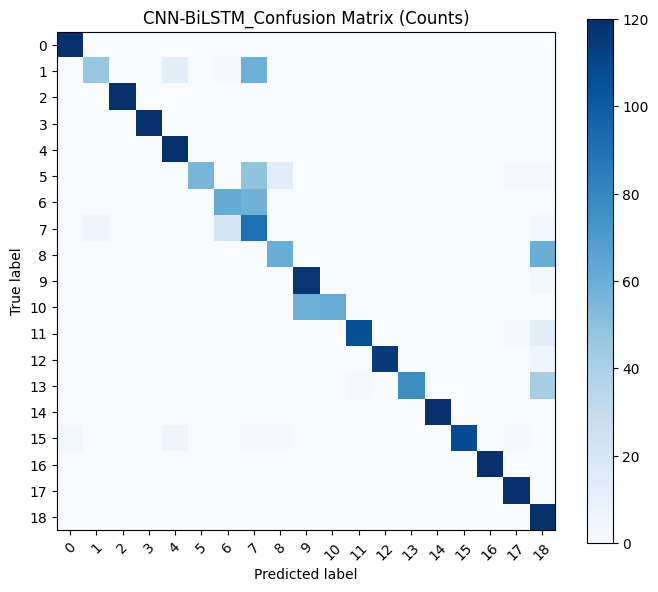

In [49]:
model_to_eval= cnn_bilstm

y_prob_cnn_bilstm= model_to_eval.predict(X_test_scaled, verbose=0)
y_pred_cnn_bilstm= np.argmax(y_prob_cnn_bilstm, axis=1)


print("Classification report (per class):")
print(classification_report(y_test_c, y_pred_cnn_bilstm, digits=2))

cm_cnn_bilstm= confusion_matrix(y_test_c, y_pred_cnn_bilstm)
print("Confusion matrix shape:", cm_cnn_bilstm.shape)

plt.figure(figsize=(7, 6))
plt.imshow(cm_cnn_bilstm, interpolation="nearest", cmap="Blues")
plt.title("CNN-BiLSTM_Confusion Matrix (Counts)")
plt.colorbar()

num_classes= cm_cnn_bilstm.shape[0]
plt.xticks(np.arange(num_classes), rotation=45)
plt.yticks(np.arange(num_classes))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("CNN-BiLSTM_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()



In [50]:
model_name= "CNN_BiLSTM "  
cm= confusion_matrix(y_test_c, y_pred_cnn_bilstm)
cm_off= cm.copy()
np.fill_diagonal(cm_off, 0)
k =6  
flat_idx= np.argsort(cm_off.ravel())[::-1]  
rows= []
for idx in flat_idx:
    i, j= np.unravel_index(idx, cm_off.shape)
    count= int(cm_off[i, j])
    if count== 0:
        break
    rows.append({
        "True label": i,
        "Pred label": j,
        "True activity": activity_names[i],
        "Pred activity": activity_names[j],
        "Count (samples)": count})
    if len(rows)== k:
        break

top_conf_df = pd.DataFrame(rows)
display(top_conf_df)
top_conf_df.to_csv(f"{model_name}_top_confusions.csv", index=False)
print(f"Saved: {model_name}_top_confusions.csv")



,True label,Pred label,True activity,Pred activity,Count (samples)
0,8,18,walking in a parking lot (A8),playing basketball (A18),60
1,10,9,walking with slop on a treadmill with a speed ...,walking on a flat treadmill with a speed of 4 ...,59
2,1,7,standing (A1),moving around in an elevator (A7),59
3,6,7,standing in an elevator still (A6),moving around in an elevator (A7),58
4,5,7,descending stairs (A5),moving around in an elevator (A7),48
5,13,18,exercising on a cross trainer (A13),playing basketball (A18),42


Saved: CNN_BiLSTM _top_confusions.csv


In [53]:
def summarize_models(models_dict, X_test, y_test):
    rows= []
    for name, model in models_dict.items():
        # predict
        y_prob= model.predict(X_test, verbose=0)
        y_pred= np.argmax(y_prob, axis=1)

        #accuracy
        acc= accuracy_score(y_test, y_pred)

        #macro metrics
        p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
            y_test, y_pred, average="macro", zero_division=0)
        #weighted metric
        p_w, r_w, f1_w, _ =precision_recall_fscore_support(
            y_test, y_pred, average="weighted", zero_division=0)


        params = model.count_params() if hasattr(model, "count_params") else None

        rows.append({
            "Model": name,
            "Accuracy": acc,
            "Precision (Macro)": p_macro,
            "Recall (Macro)": r_macro,
            "F1 (Macro)": f1_macro,
            "Precision (Weighted)": p_w,
            "Recall (Weighted)": r_w,
            "F1 (Weighted)": f1_w,
            "#Params": params})

    df= pd.DataFrame(rows).sort_values("F1 (Macro)", ascending=False)
    metric_cols= [c for c in df.columns if c not in ["Model", "#Params"]]
    df[metric_cols]= df[metric_cols].round(4)
    return df

models_dict ={
    "Baseline 1D-CNN": model,
    "Fusion (5-branch)": fusion_model,
    "TCN": tcn_model,
    "TCN v1": tcn_model_v1,
    "TCN v2": tcn_model_v2,
    "CNN+BiLSTM": cnn_bilstm}

results_table= summarize_models(models_dict, X_test_scaled, y_test_c)
results_table.to_csv("model_results_summary.csv", index=False)
results_table

,Model,Accuracy,Precision (Macro),Recall (Macro),F1 (Macro),Precision (Weighted),Recall (Weighted),F1 (Weighted),#Params
1,Fusion (5-branch),0.8715,0.9055,0.8715,0.8700,0.9055,0.8715,0.8700,308499
3,TCN v1,0.8461,0.8920,0.8461,0.8473,0.8920,0.8461,0.8473,797331
0,Baseline 1D-CNN,0.8399,0.8981,0.8399,0.8431,0.8981,0.8399,0.8431,65811
2,TCN,0.8311,0.8785,0.8311,0.8332,0.8785,0.8311,0.8332,215635
5,CNN+BiLSTM,0.8162,0.8814,0.8162,0.8188,0.8814,0.8162,0.8188,164627
4,TCN v2,0.8105,0.8725,0.8105,0.8159,0.8725,0.8105,0.8159,590483


In [54]:
models_dict={
    "Baseline 1D-CNN": model,          
    "Fusion (5-branch)":fusion_model, 
    "TCN":tcn_model,                 
    "TCN v1": tcn_model_v1,            
    "TCN v2":tcn_model_v2,           
    "CNN+BiLSTM":cnn_bilstm }

def collect_top_confusions(models_dict, X_test, y_test, activity_names, k=3):
    rows=[]
    num_classes=len(activity_names)
    labels= np.arange(num_classes)

    for model_name, model in models_dict.items():
       
        y_prob= model.predict(X_test, verbose=0)
        y_pred= np.argmax(y_prob, axis=1)

        # confusion matrix
        cm=confusion_matrix(y_test, y_pred, labels=labels)
        cm_off= cm.copy()
        np.fill_diagonal(cm_off, 0)

        #sorting
        flat_idx= np.argsort(cm_off.ravel())[::-1]

        taken= 0
        for idx in flat_idx:
            i, j= np.unravel_index(idx, cm_off.shape)
            count=int(cm_off[i, j])
            if count== 0:
                break

            rows.append({
                "Model": model_name,
                "True label": int(i),
                "Pred label": int(j),
                "True activity": activity_names[i],
                "Pred activity": activity_names[j],
                "Count (samples)": count})

            taken+=1
            if taken== k:
                break
    df= pd.DataFrame(rows)
    #sorting
    df= df.sort_values(["Model", "Count (samples)"],ascending=[True, False]).reset_index(drop=True)
    return df

top3_all= collect_top_confusions(models_dict,X_test_scaled,y_test_c,activity_names, k=2)

display(top3_all)
top3_all.to_csv("Top3_confusions_all_models.csv", index=False)
print("Saved: Top3_confusions_all_models.csv")


,Model,True label,Pred label,True activity,Pred activity,Count (samples)
0,Baseline 1D-CNN,10,9,walking with slop on a treadmill with a speed ...,walking on a flat treadmill with a speed of 4 ...,60
1,Baseline 1D-CNN,5,7,descending stairs (A5),moving around in an elevator (A7),60
2,CNN+BiLSTM,8,18,walking in a parking lot (A8),playing basketball (A18),60
3,CNN+BiLSTM,10,9,walking with slop on a treadmill with a speed ...,walking on a flat treadmill with a speed of 4 ...,59
4,Fusion (5-branch),8,18,walking in a parking lot (A8),playing basketball (A18),60
5,Fusion (5-branch),1,7,standing (A1),moving around in an elevator (A7),60
6,TCN,0,14,sitting (A0),cycling on an exercise bike in horizontal (A14),60
7,TCN,1,7,standing (A1),moving around in an elevator (A7),60
8,TCN v1,1,7,standing (A1),moving around in an elevator (A7),60
9,TCN v1,10,9,walking with slop on a treadmill with a speed ...,walking on a flat treadmill with a speed of 4 ...,59


Saved: Top3_confusions_all_models.csv
